In [41]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

# TODO
* Play around with different models
* Evaluate performances
* Feature Engineering?

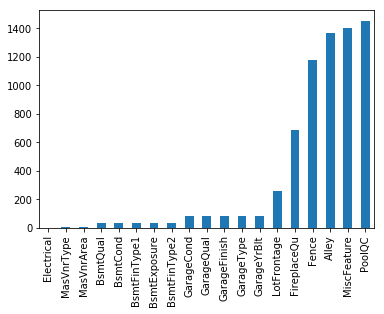

In [2]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [3]:
train['MSZoning'][0:100]

0          RL
1          RL
2          RL
3          RL
4          RL
5          RL
6          RL
7          RL
8          RM
9          RL
10         RL
11         RL
12         RL
13         RL
14         RL
15         RM
16         RL
17         RL
18         RL
19         RL
20         RL
21         RM
22         RL
23         RM
24         RL
25         RL
26         RL
27         RL
28         RL
29         RM
30    C (all)
31         RL
32         RL
33         RL
34         RL
35         RL
36         RL
37         RL
38         RL
39         RL
40         RL
41         RL
42         RL
43         RL
44         RL
45         RL
46         RL
47         FV
48         RM
49         RL
50         RL
51         RM
52         RM
53         RL
54         RL
55         RL
56         FV
57         RL
58         RL
59         RL
60         RL
61         RM
62         RL
63         RM
64         RL
65         RL
66         RL
67         RL
68         RM
69         RL
70         RL
71    

# EDA

In [4]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
prices = train['SalePrice']

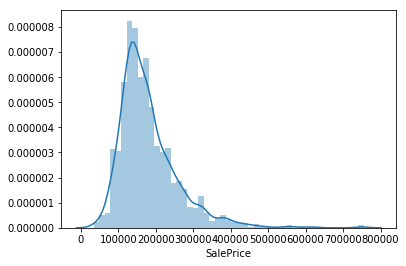

In [8]:
sns.distplot(train['SalePrice'])

* Deviates from normal distribution and has positive rightward skew

In [9]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


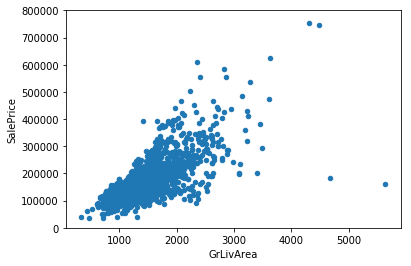

In [10]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

* Leave out ID column when preprocessing

In [11]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

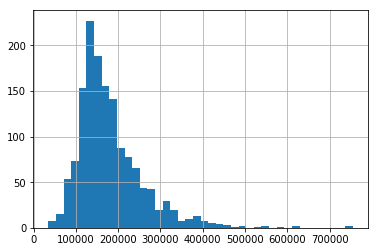

In [12]:
train['SalePrice'].hist(bins = 40)

* We see that SalePrice has a skew to the left and that it does not follow a uniform distribution.  Therefore, we use log1p to remove this skewness. 

In [13]:
train = train[train.GrLivArea < 4500] # From above graph of SalePrice vs GrlivingArea 
train.reset_index(drop=True, inplace=True)
salePrices = train['SalePrice'].reset_index(drop=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

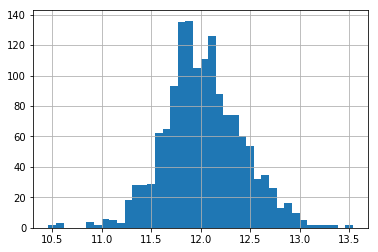

In [15]:
train['SalePrice'].hist(bins = 40)

In [16]:
trainFeatures = train.drop(['SalePrice'], axis = 1) # This is what we predict so we drop from our features we predict it on
testFeatures = test
features = pd.concat([trainFeatures, testFeatures]).reset_index(drop = True)

### Let's take a look at our Missing Data

In [18]:
featuresNA = (features.isnull().sum() / len(features)) * 100
featuresNA = featuresNA.drop(featuresNA[featuresNA == 0].index).sort_values(ascending = False)[:40]
missingData = pd.DataFrame({'Missing Ratio' : featuresNA})
missingData.head(30)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


### Examine Correlation using HeatMap

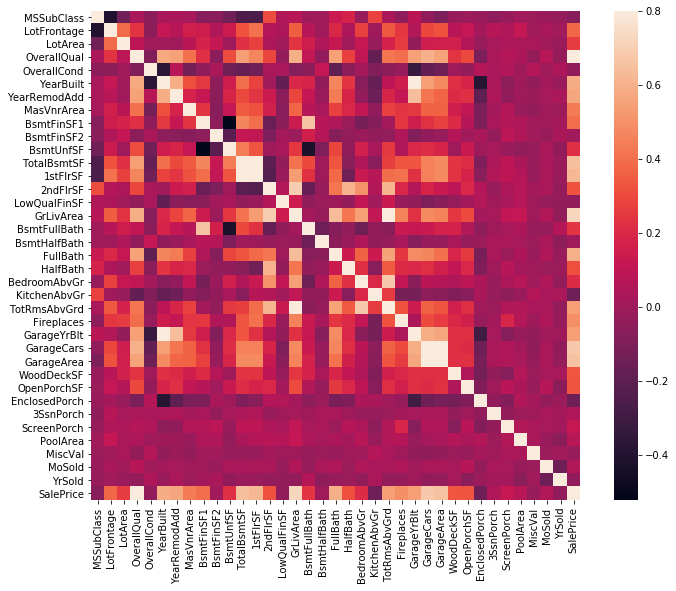

In [19]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square = True)

### Fill our Missing Values

In [20]:
# Converting numerical columns that are actually categorical to strs
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
features['OverallCond'] = features['OverallCond'].astype(str)
features['MSSubClass'] = features['MSSubClass'].astype(str)

# Next we fill the appropriate columns with correct values based on the description
features['Functional'] = features['Functional'].fillna('Typ') # Typical Functionality
features['Electrical'] = features['Electrical'].fillna("SBrkr") # Standard Circuit Breakers & Romex
features['KitchenQual'] = features['KitchenQual'].fillna("TA") # Typical/Average

# Median value since high std
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Mode Value
for column in ('Exterior1st', 'Exterior2nd', 'SaleType'):
    features[column] = features[column].fillna(features[column].mode()[0])

# Drop features because almost all values are basically the same and/or None (PoolQC) so useless for prediction
features = features.drop(['Utilities', 'Street', 'PoolQC'], axis = 1)

# The missing values for columns that recourse to None
convertToNone = []
for column in features.columns:
    if features[column].dtype == object:
        convertToNone.append(column)
features.update(features[convertToNone].fillna('None'))

# Converting missing values to 0 for numerical columns
numericDTypes =  ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
convertToInt = []
for column in features.columns:
    if features[column].dtype in numericDTypes:
        convertToInt.append(column)
features.update(features[convertToInt].fillna(0))

In [21]:
# Make sure we no longer have anymore missing data
featuresNA = (features.isnull().sum() / len(features)) * 100
featuresNA = featuresNA.drop(featuresNA[featuresNA == 0].index).sort_values(ascending = False)
missingData = pd.DataFrame({'Missing Ratio' :featuresNA})
missingData.head()

,Missing Ratio


### Now we are going to identify skewed features

In [22]:
numericsInDF = features.dtypes[features.dtypes != 'object'].index
skewedFeatures = features[numericsInDF].apply(lambda x: skew(x)).sort_values(ascending = False)
highSkew = skewedFeatures[abs(skewedFeatures) > .75]
highSkewIndices = highSkew.index

### Apply Box Cox Transformation for the heavily skewed features

In [23]:
for idx in highSkewIndices:
    features[idx] = boxcox1p(features[idx], boxcox_normmax(features[idx] + 1))

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


### Add some additional columns

In [24]:
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features['YrBltAndRemod']= features['YearBuilt'] + features['YearRemodAdd']
features['TotalBath'] = (features['FullBath'] + (0.5 * features['HalfBath']) + features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
features['TotalPorchSF'] = (features['OpenPorchSF'] + features['3SsnPorch'] + features['EnclosedPorch'] + features['ScreenPorch'] + features['WoodDeckSF'])

In [25]:
features['Haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['Has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['HasGarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['HasBsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['HasFireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### Convert Categorical to Numerical for Modeling and resplit Data

In [26]:
finalFeatures = pd.get_dummies(features).reset_index(drop = True)
newTrain = finalFeatures.iloc[:len(y), :] # splits up to length of train
newTest = finalFeatures.iloc[len(y):, :]
newTrain.shape, y.shape, newTest.shape

((1458, 341), (1458,), (1459, 341))

In [27]:
from sklearn.model_selection import train_test_split
y = np.expm1(y)

In [28]:
y

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1453    175000.0
1454    210000.0
1455    266500.0
1456    142125.0
1457    147500.0
Name: SalePrice, Length: 1458, dtype: float64

### Train Test Split

In [244]:
X_train, X_val, y_train, y_val = train_test_split(newTrain, y, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [28]:
output_train = X_train
output_train['SalePrice'] = y
output_train.to_csv('train_new.csv', index = False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [245]:
condensedTest = X_val[['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                              'GrLivArea', 'Fireplaces', 'ScreenPorch', 'MSSubClass_160', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RL', 'LandSlope_Gtl', 'LandSlope_Mod', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 
'Neighborhood_Edwards', 'Neighborhood_StoneBr', 'Condition1_Artery', 'Condition1_RRAe', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'BsmtExposure_Gd', 'Heating_Grav', 'KitchenQual_Ex', 'Functional_Maj2', 
      'Functional_Mod', 'GarageType_2Types', 'GarageQual_Ex', 'SaleCondition_Normal']]

In [246]:
condensedData = X_train[['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                              'GrLivArea', 'Fireplaces', 'ScreenPorch', 'MSSubClass_160', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RL', 'LandSlope_Gtl', 'LandSlope_Mod', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 
'Neighborhood_Edwards', 'Neighborhood_StoneBr', 'Condition1_Artery', 'Condition1_RRAe', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'BsmtExposure_Gd', 'Heating_Grav', 'KitchenQual_Ex', 'Functional_Maj2', 
      'Functional_Mod', 'GarageType_2Types', 'GarageQual_Ex', 'SaleCondition_Normal']]






In [29]:
finalTest = newTest[['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                              'GrLivArea', 'Fireplaces', 'ScreenPorch', 'MSSubClass_160', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RL', 'LandSlope_Gtl', 'LandSlope_Mod', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 
'Neighborhood_Edwards', 'Neighborhood_StoneBr', 'Condition1_Artery', 'Condition1_RRAe', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'BsmtExposure_Gd', 'Heating_Grav', 'KitchenQual_Ex', 'Functional_Maj2', 
      'Functional_Mod', 'GarageType_2Types', 'GarageQual_Ex', 'SaleCondition_Normal']]

In [104]:
condensedData.to_csv('condensedData.csv', index = False)

In [ ]:
# (Intercept)              LotArea          OverallQual            YearBuilt 
#                    1                    2                    3                    4 
#         YearRemodAdd            BsmtUnfSF          TotalBsmtSF            X1stFlrSF 
#                    5                    7                    8                    9 
#            X2ndFlrSF            GrLivArea           Fireplaces          ScreenPorch 
#                   10                   11                   16                   22 
#       MSSubClass_160     MSZoning_C..all.          MSZoning_FV          MSZoning_RL 
#                   28                   32                   33                   35 
#        LandSlope_Gtl        LandSlope_Mod Neighborhood_BrkSide Neighborhood_Crawfor 
#                   40                   41                   44                   45 
# Neighborhood_Edwards Neighborhood_StoneBr    Condition1_Artery      Condition1_RRAe 
#                   46                   52                   53                   55 
#        OverallCond_3        OverallCond_4        OverallCond_5        OverallCond_6 
#                   62                   63                   64                   65 
#      BsmtExposure_Gd         Heating_Grav       KitchenQual_Ex      Functional_Maj2 
#                   98                  105                  110                  112 
#       Functional_Mod    GarageType_2Types        GarageQual_Ex SaleCondition_Normal 
#                  115                  118                  119                  132 

In [86]:
condensedTest.to_csv('condensedTest.csv', index = False)

## Model Development

In [31]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold as kfolds

# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
# def cv_rmse(model, X=condensedData):
#     rmse = np.sqrt(-cross_val_score(model, X, y,
#                                     scoring="neg_mean_squared_error",
#                                     cv=kfolds))
#     return (rmse)


In [32]:
# default_param<-list(
#         objective = "reg:linear",
#         booster = "gbtree",
#         eta=0.05, #default = 0.3
#         gamma=0,
#         max_depth=3, #default=6
#         min_child_weight=4, #default=1
#         subsample=1,
#         colsample_bytree=1
# )


# newTrain = finalFeatures.iloc[:len(y), :] # splits up to length of train
# newTest = finalFeatures.iloc[len(y):, :]

xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=4,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006, eta = 0.05)

### Now let's train on condensedData

In [33]:
model = xgboost.fit(condensedData, y_train)

[22:31:12] WARNING: /Users/sdas115/Documents/Berkeley/W207/W207-Final-Project/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.


### Get our Predictions

In [256]:
predictions = model.predict(condensedTest)

In [258]:
from sklearn.metrics import mean_squared_log_error
print(sqrt(mean_squared_log_error(y_val, predictions)))
rmsle(y_val, predictions)

0.12636574758723032


20983.80439065809

In [134]:
# model.score(y_val, predictions)

In [89]:
score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

AttributeError: 'DataFrame' object has no attribute 'n_splits'

### Train on full dataset

In [ ]:
model = xgboost.fit(newTrain, y)

In [35]:
finalPredictions = model.predict(newTest) # predicts on test dataset

In [36]:
finalPredictions

array([128426.164, 160651.55 , 183741.28 , ..., 165280.7  , 120054.42 ,
       224059.45 ], dtype=float32)

### Convert to csv for Kaggle

In [53]:
finalDf = pd.DataFrame()
test = pd.read_csv('./test.csv')
finalDf['Id'] = test['Id'] # getting ID column for kaggle
finalDf['SalePrice'] = pd.DataFrame(data= finalPredictions, columns = ['SalePrice']) # gets SalesPrice data and converts array to DF
finalDf.to_csv('kaggleFile.csv', index = False) # csv to Kaggle